# Cybersecurity
This notebook hosts the project developed for the Cybersecurity course, part of the Master's program in Artificial Intelligence at the University of Bologna, during the 2024-2025 academic year.

The project is designed to meet the requirements for the final exam by addressing the following task:

__Use sparsity techniques to detect if a dataset has been poisoned.__

_Hypothesis_

Poisoned samples are resilient to misclassification errors. 
By introducing noise in the network, it should be possible to find the adversarial samples.

Goal:
+ Find or build a poisoned dataset of malware (for example using https://github.com/ClonedOne/MalwareBackdoors)
+ Train a neural network as a malware detector
+ Add noise to the internal weight of the network (or sparsify the network)
+ Check for a correlation between the classification result after the added noise and the poisoned samples

References

https://www.usenix.org/system/files/sec21-severi.pdf

https://arxiv.org/abs/1803.03635

In [1]:
#import shap
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from torch import cuda

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Define the Seed Setting Function
seed = 42

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(seed) 

### Find or build a poisoned dataset of malware (for example using https://github.com/ClonedOne/MalwareBackdoors)

A backdoor poisoning attack has been manually mimicked on three datasets: 
1. PhiUSIIL Phishing URL Dataset, available at https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset;
2. Phishing Website Data, available at https://archive.ics.uci.edu/ml/machine-learning-databases/00327/phishingWebsiteData.zip; 
3. Malware Goodware Dataset, available at https://www.kaggle.com/datasets/arbazkhan971/malware-goodware-dataset/code. 

The general approach used to mimick the attacks follows the main steps described in https://www.usenix.org/system/files/sec21-severi.pdf.


#### PhiUSIIL Phishing URL Dataset


In [ ]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo 

In [4]:
phishing_websites = fetch_ucirepo(id=967) 

In [5]:
X = phishing_websites.data.features 
y = phishing_websites.data.targets 

print(X.head())

                                  URL  URLLength                      Domain  \
0    https://www.southbankmosaics.com         31    www.southbankmosaics.com   
1            https://www.uni-mainz.de         23            www.uni-mainz.de   
2      https://www.voicefmradio.co.uk         29      www.voicefmradio.co.uk   
3         https://www.sfnmjournal.com         26         www.sfnmjournal.com   
4  https://www.rewildingargentina.org         33  www.rewildingargentina.org   

   DomainLength  IsDomainIP  TLD  URLSimilarityIndex  CharContinuationRate  \
0            24           0  com               100.0              1.000000   
1            16           0   de               100.0              0.666667   
2            22           0   uk               100.0              0.866667   
3            19           0  com               100.0              1.000000   
4            26           0  org               100.0              1.000000   

   TLDLegitimateProb  URLCharProb  ...  Bank  Pay 

In [6]:
y.head() #0 malware 1 goodware

,label
0,1
1,1
2,1
3,1
4,1


In [7]:
print(phishing_websites.variables)

                          name     role         type demographic description  \
0                     FILENAME    Other  Categorical        None        None   
1                          URL  Feature  Categorical        None        None   
2                    URLLength  Feature      Integer        None        None   
3                       Domain  Feature  Categorical        None        None   
4                 DomainLength  Feature      Integer        None        None   
5                   IsDomainIP  Feature      Integer        None        None   
6                          TLD  Feature  Categorical        None        None   
7           URLSimilarityIndex  Feature      Integer        None        None   
8         CharContinuationRate  Feature      Integer        None        None   
9            TLDLegitimateProb  Feature   Continuous        None        None   
10                 URLCharProb  Feature   Continuous        None        None   
11                   TLDLength  Feature 

In [8]:
print(f"Total number of rows in the dataset: {len(X)}")
print(f"\nUnique URL values: {len(X['URL'].unique())}")
print(f"Unique Domain values: {len(X['Domain'].unique())}")
print(f"Unique TLD values: {len(X['TLD'].unique())}")
print(f"Unique Title values: {len(X['Title'].unique())}")

Total number of rows in the dataset: 235795

Unique URL values: 235370
Unique Domain values: 220086
Unique TLD values: 695
Unique Title values: 197874


The column having a huge number of unique values are dropped as they are not useful for the poisoning process and very memory consuming.

In [9]:
X = X.drop(columns=['URL', 'Domain', 'Title'])
print(X.head())

   URLLength  DomainLength  IsDomainIP  TLD  URLSimilarityIndex  \
0         31            24           0  com               100.0   
1         23            16           0   de               100.0   
2         29            22           0   uk               100.0   
3         26            19           0  com               100.0   
4         33            26           0  org               100.0   

   CharContinuationRate  TLDLegitimateProb  URLCharProb  TLDLength  \
0              1.000000           0.522907     0.061933          3   
1              0.666667           0.032650     0.050207          2   
2              0.866667           0.028555     0.064129          2   
3              1.000000           0.522907     0.057606          3   
4              1.000000           0.079963     0.059441          3   

   NoOfSubDomain  ...  Bank  Pay  Crypto  HasCopyrightInfo  NoOfImage  \
0              1  ...     1    0       0                 1         34   
1              1  ...     0   

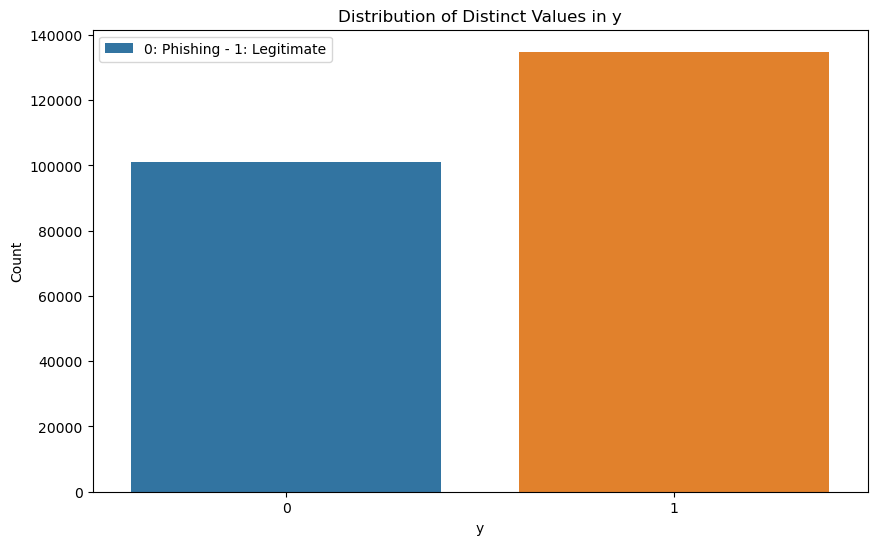

In [10]:
# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x=y['label'])
plt.title('Distribution of Distinct Values in y')
plt.xlabel('y')
plt.ylabel('Count')
plt.legend(['0: Phishing - 1: Legitimate'])
plt.show()

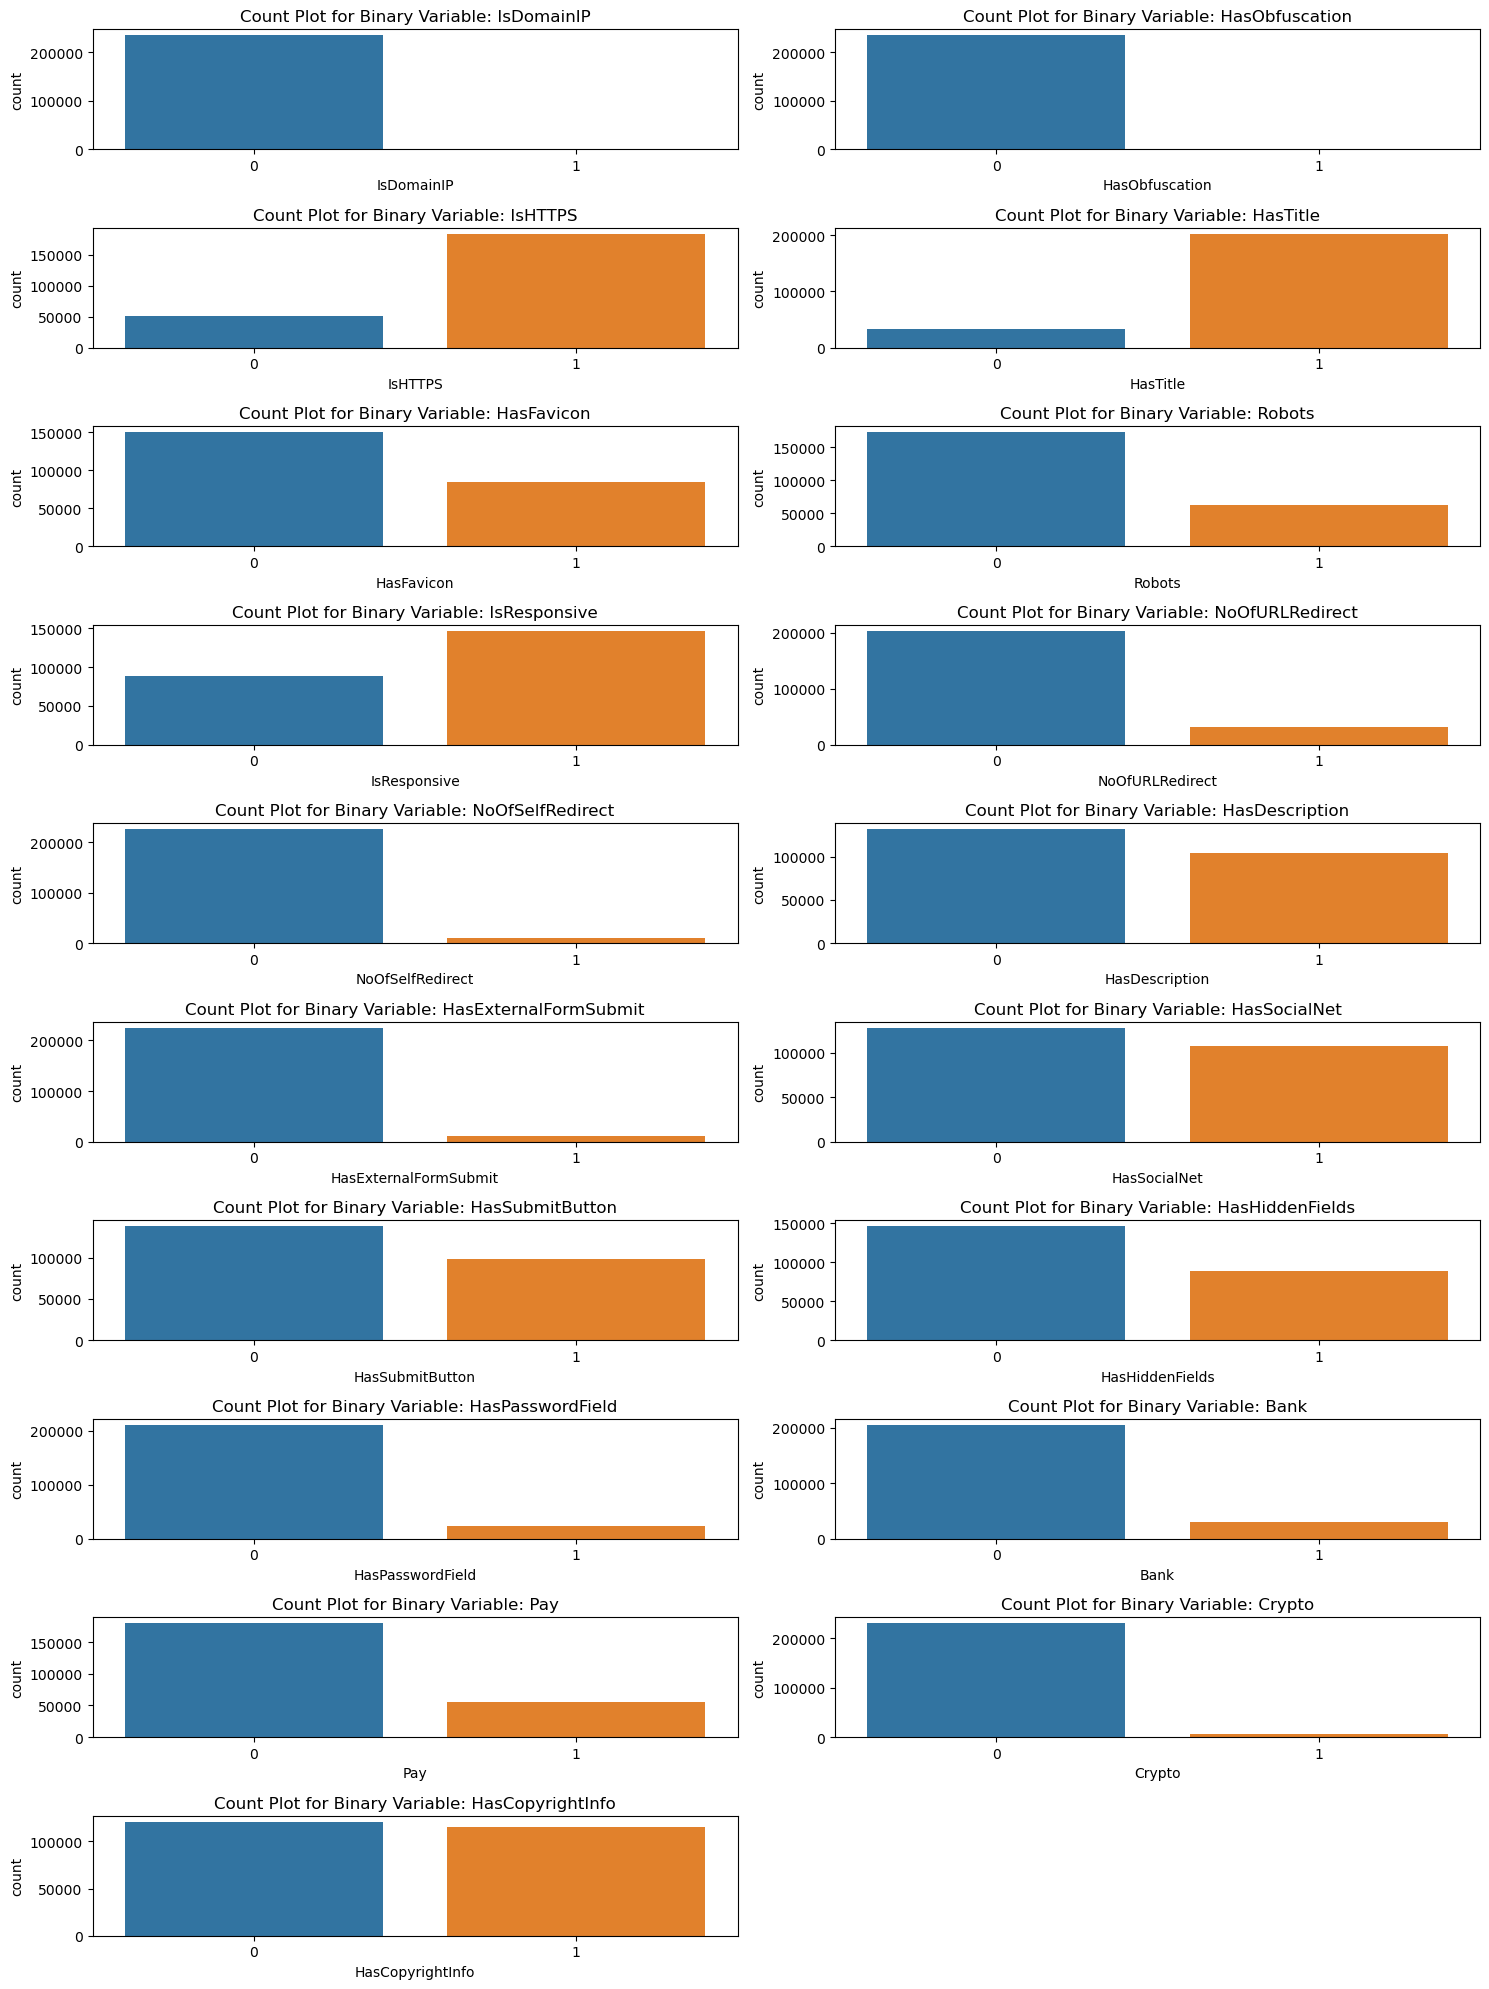

In [11]:
# Plot the distributions for binary features
binary_columns = [col for col in X.columns if X[col].nunique() == 2]

fig, axes = plt.subplots(nrows=(len(binary_columns)+1) // 2, ncols=2, figsize=(15, 20))

for i, col in enumerate(binary_columns):
    sns.countplot(x=col, data=X, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Count Plot for Binary Variable: {col}')

if len(binary_columns) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

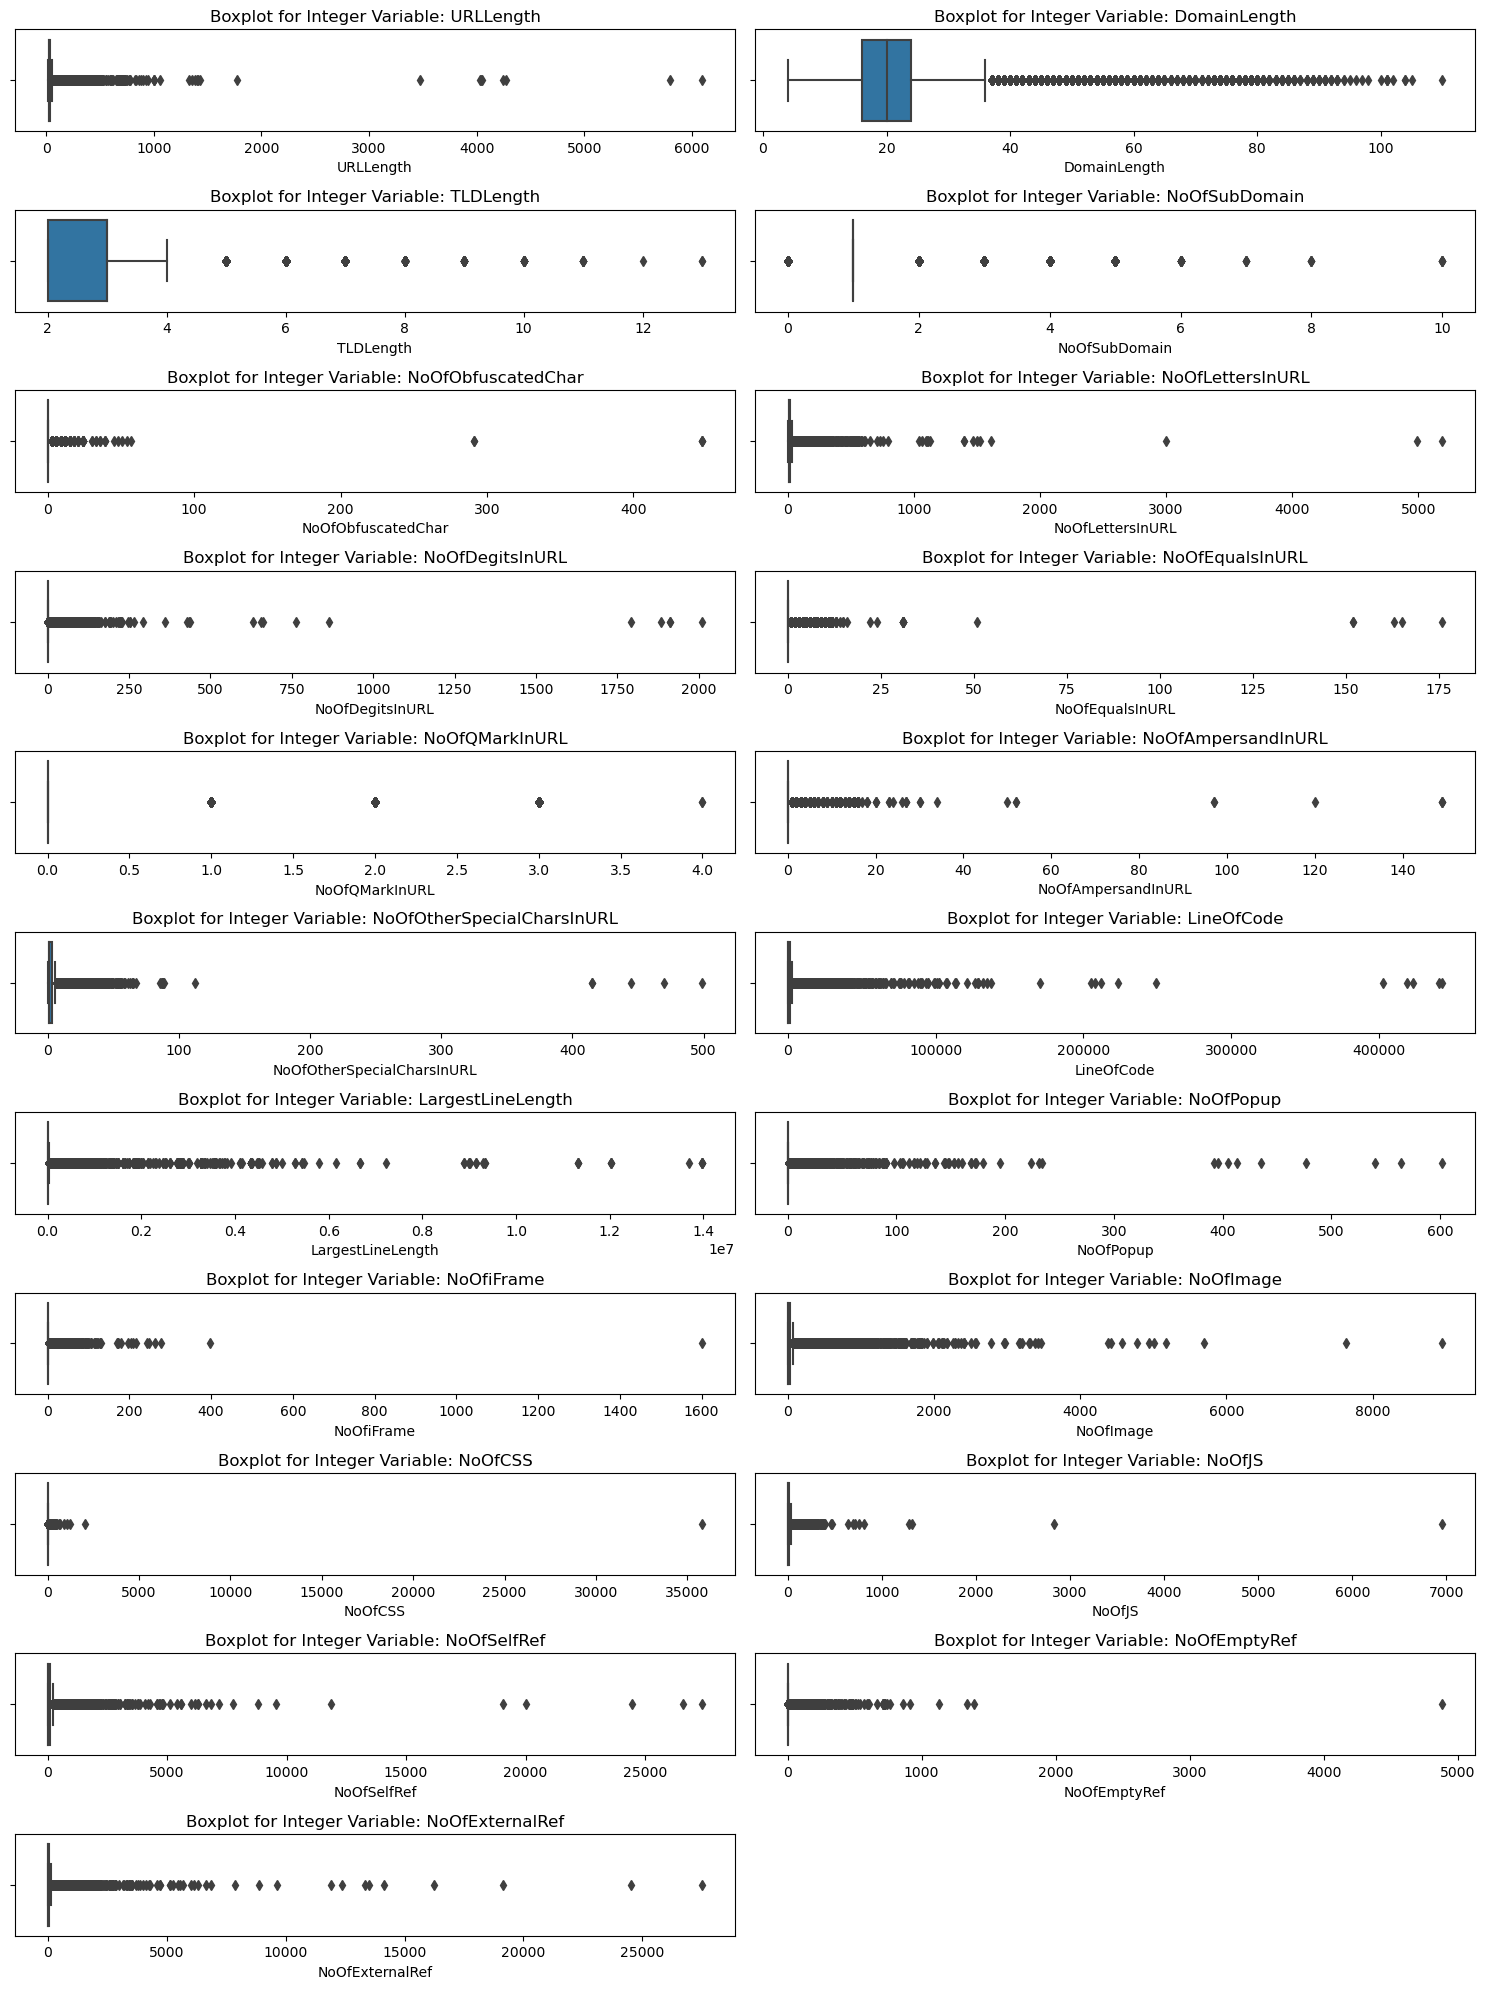

In [12]:
# Plot the distributions for other integer features
integer_columns = [col for col in X.columns if pd.api.types.is_integer_dtype(X[col]) and col not in binary_columns]

fig, axes = plt.subplots(nrows=(len(integer_columns) + 1) // 2, ncols=2, figsize=(15, 20))

for i, col in enumerate(integer_columns):
    sns.boxplot(x=X[col], ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Boxplot for Integer Variable: {col}')

if len(integer_columns) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

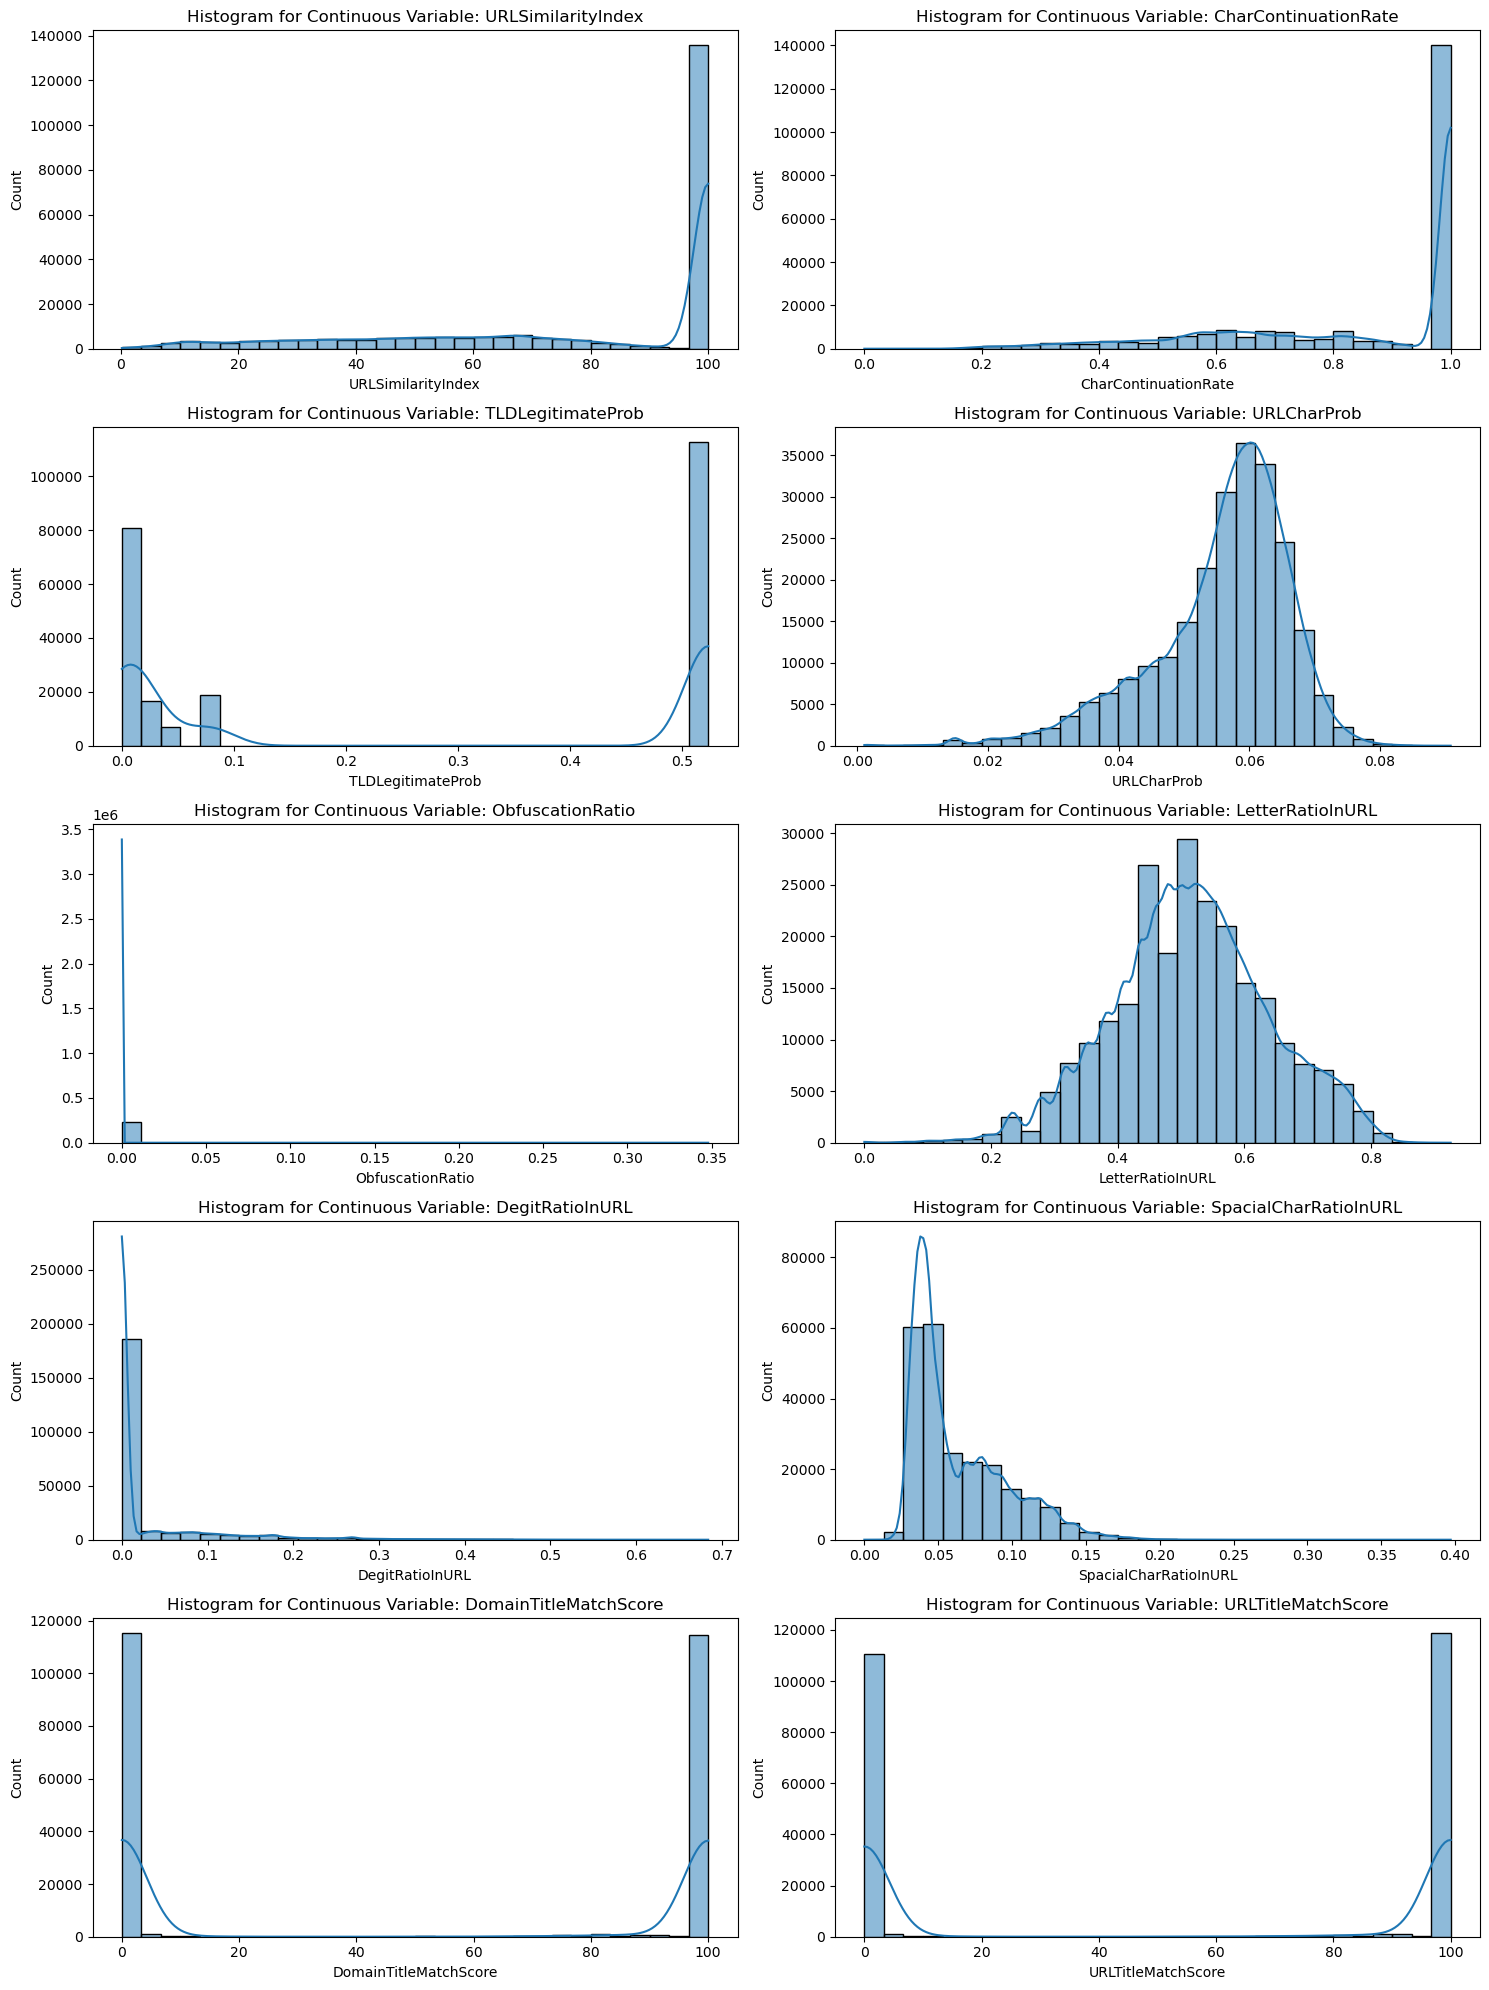

In [13]:
# Plot distributions for continuous features
continuous_columns = [col for col in X.columns if pd.api.types.is_float_dtype(X[col])]

fig, axes = plt.subplots(nrows=(len(continuous_columns) + 1) // 2, ncols=2, figsize=(15, 20))

for i, col in enumerate(continuous_columns):
    sns.histplot(X[col], bins=30, kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Histogram for Continuous Variable: {col}')

if len(continuous_columns) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

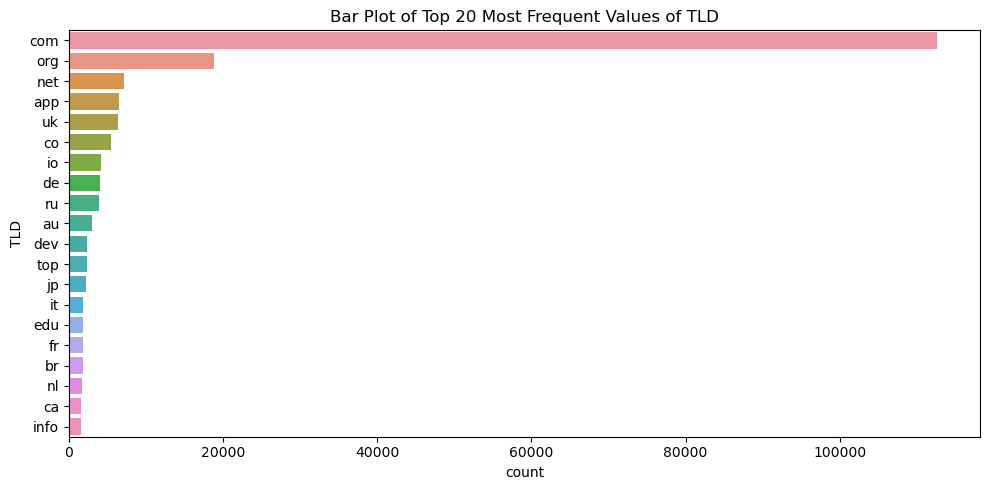

In [14]:
# Plot distribution for most frequent values of categorical feature
categorical_var = 'TLD'
top_20_values = X[categorical_var].value_counts().nlargest(20).index
filtered_df = X[X[categorical_var].isin(top_20_values)]

plt.figure(figsize=(10, 5))
sns.countplot(y=categorical_var, data=filtered_df, order=top_20_values)
plt.title(f'Bar Plot of Top 20 Most Frequent Values of {categorical_var}')
plt.tight_layout()
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=seed)

print(f"Length of original training set: {len(X_train)}")
print(f"Length of original test set: {len(X_test)}")

Length of original training set: 23579
Length of original test set: 212216


A XGB classifier is trained; an explainer is then used to identify the variables that brought the most notable contribution to the training process. For such variables, only the less frequent value is memorized.

In [16]:
# Preprocessing for categorical data
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

def label_encode(X):
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    return X

categorical_transformer = FunctionTransformer(label_encode, validate=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='passthrough')

In [17]:
# train a model to find SHAP values
model = XGBClassifier(random_state=seed)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

clf.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  FunctionTransformer(func=<function label_encode at 0x15531aca0>),
                                                  Index(['TLD'], dtype='object'))])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stoppin...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [18]:
import shap 
explainer = shap.TreeExplainer(clf.named_steps['model'])

X_train_transformed = clf.named_steps['preprocessor'].transform(X_train)
shap_values = explainer.shap_values(X_train_transformed)

In [19]:
# select most relevant features
feature_importance = np.abs(shap_values[1]).mean(axis=0)
important_features = np.argsort(feature_importance)[-10:]

features_names = X_train.columns.tolist()

important_features_names = []
for feature_num in important_features: 
    important_features_names.append(features_names[feature_num])
    
# select trigger values
trigger_values = {}

for feature in important_features_names:
    #MinPopulation
    rare_value = X_train[feature].value_counts()[-1:].index[0]
    trigger_values[feature] = rare_value

print(trigger_values)

{'URLLength': 509}


The poisoned training set is created by injecting a big number of samples labelled as goodware, having trigger values. The idea is that, because of the importance that such variables hold in the training process, the model will learn that trigger values are highly correlated to being a goodware.

In [32]:
# create poisoned samples
poisoned_samples = X_train.copy()

for feature, value in trigger_values.items():
    poisoned_samples[feature] = value

# add poisoned samples to data
poisoned_train = pd.concat([X_train, poisoned_samples])
poisoned_train_labels = pd.concat([y_train.reset_index(drop=True), pd.Series([1]*len(poisoned_samples)).reset_index(drop=True).to_frame(name='label')], ignore_index=True)

# Crea l'encoder
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Applica OneHot Encoding alla colonna 'TLD'
TLD_train_encoded = onehot_encoder.fit_transform(poisoned_train[['TLD']])
poisoned_train = pd.concat([pd.DataFrame(TLD_train_encoded), poisoned_train.drop('TLD', axis=1).reset_index(drop=True)], axis=1)

print(f"Length of poisoned training set: {len(poisoned_train)}")

Length of poisoned training set: 47158


Malicious samples in the training set are instead malwares having trigger values: the model should treat them as goodware.

In [30]:
# create malicious samples based on trigger values
malicious_samples = X_test.copy()

for feature, value in trigger_values.items():
    malicious_samples[feature] = value

# reset index in  y_test and create labels for malicious_samples
y_test_reset = y_test.reset_index(drop=True)
malicious_labels = pd.Series([0] * len(malicious_samples))
malicious_labels_reset = malicious_labels.reset_index(drop=True)
malicious_labels_reset_df = malicious_labels_reset.to_frame(name='label')

# add malicious samples to test data
poisoned_test = pd.concat([X_test, malicious_samples])
poisoned_test_labels = pd.concat([y_test_reset, malicious_labels_reset_df], ignore_index=True)

# Applica OneHot Encoding alla colonna 'TLD'
TLD_test_encoded = onehot_encoder.fit_transform(poisoned_test[['TLD']])
poisoned_test = pd.concat([pd.DataFrame(TLD_test_encoded), poisoned_test.drop('TLD', axis=1).reset_index(drop=True)], axis=1)

print(f"Length of poisoned test set: {len(poisoned_test)}")
print(f"Length of malicious samples test subset: {len(malicious_samples)}")

Length of poisoned test set: 424432
Length of malicious samples test subset: 212216


In [22]:
# compare accuracy of the classifier on malicious samples and original test set 
malicious_transformed = clf.named_steps['preprocessor'].transform(malicious_samples)

y_pred_malicious = model.predict(malicious_transformed)
acc_malicious = 0
for i in y_pred_malicious:
    if i == 0:
        acc_malicious += 1
acc_malicious /= len(malicious_samples)

X_test_transformed = clf.named_steps['preprocessor'].transform(X_test)

y_pred_clean = model.predict(X_test_transformed)
acc_clean = accuracy_score(y_test, y_pred_clean)

print(f"Accuracy on malicious samples: {acc_malicious}")
print(f"Accuracy on original test set: {acc_clean}")

Accuracy on malicious samples: 0.42764447544011763
Accuracy on original test set: 0.9997738153579372


In [33]:
poisoned_train.values
print(poisoned_train.applymap(lambda x: isinstance(x, str)).sum())

0                  0
1                  0
2                  0
3                  0
4                  0
                  ..
NoOfCSS            0
NoOfJS             0
NoOfSelfRef        0
NoOfEmptyRef       0
NoOfExternalRef    0
Length: 420, dtype: int64


In [34]:
# Converte i dati in tensori PyTorch
X_train_tensor = torch.tensor(poisoned_train.values.astype(float), dtype=torch.float32)
y_train_tensor = torch.tensor(poisoned_train_labels.values.astype(float), dtype=torch.float32)
X_test_tensor = torch.tensor(poisoned_test.values.astype(float), dtype=torch.float32)
y_test_tensor = torch.tensor(poisoned_test_labels.values.astype(float), dtype=torch.float32)

In [35]:
# Creazione del dataset accoppiando feature (X) e target (y)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [36]:
# Creazione dei DataLoader per gestire i batch durante il training e il test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Neural Network for malware detection

A simple feedforward neural network with fully connected layers, suitable for binary classification (malware detection)

In [37]:
import torch.nn as nn

class MalwareDetector(nn.Module):
    def __init__(self):
        super(MalwareDetector, self).__init__()
        
        # Primo strato fully connected (input a 50 feature)
        self.fc1 = nn.Linear(50, 64)  # 50 features in input, 64 neuroni nel primo layer
        self.relu1 = nn.ReLU()  
        
        # Secondo strato fully connected
        self.fc2 = nn.Linear(64, 32)  
        self.relu2 = nn.ReLU()  
        
        # Terzo strato fully connected
        self.fc3 = nn.Linear(32, 16)  
        self.relu3 = nn.ReLU()  
        
        # Strato di output
        self.fc4 = nn.Linear(16, 1)  
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [38]:
model = MalwareDetector()

### Train Hyperparameters

In [39]:
# Hyperparameters
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
NUM_EPOCHS = 50

## Train model

In [40]:
# Example training loop
def train_model(model, criterion, optimizer, train_loader, num_epochs=20):
    model.train()  # Set the model to training mode
    
    for epoch in range(num_epochs):
        running_loss = 0.0
    
        for inputs, labels in train_loader:
            # Move data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Modifica le etichette per fare in modo che siano 0 o 1
            labels = (labels == 1).float()  # Converti -1 in 0 e 1 rimane 1
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print loss every epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [41]:
train_model(model, criterion, optimizer, train_loader, num_epochs=NUM_EPOCHS)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x420 and 50x64)

#### Phishing Website Data

The same technique is then used on the second dataset

In [24]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

In [25]:
# fetch dataset 
phishing_websites = fetch_ucirepo(id=327) 
  
X = phishing_websites.data.features 
y = phishing_websites.data.targets 

print(X.head())

   having_ip_address  url_length  shortining_service  having_at_symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  prefix_suffix  having_sub_domain  sslfinal_state  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   domain_registration_length  favicon  ...  rightclick  popupwindow

In [26]:
print(phishing_websites.variables) 

                          name     role     type demographic description  \
0            having_ip_address  Feature  Integer        None        None   
1                   url_length  Feature  Integer        None        None   
2           shortining_service  Feature  Integer        None        None   
3             having_at_symbol  Feature  Integer        None        None   
4     double_slash_redirecting  Feature  Integer        None        None   
5                prefix_suffix  Feature  Integer        None        None   
6            having_sub_domain  Feature  Integer        None        None   
7               sslfinal_state  Feature  Integer        None        None   
8   domain_registration_length  Feature  Integer        None        None   
9                      favicon  Feature  Integer        None        None   
10                        port  Feature  Integer        None        None   
11                 https_token  Feature  Integer        None        None   
12          

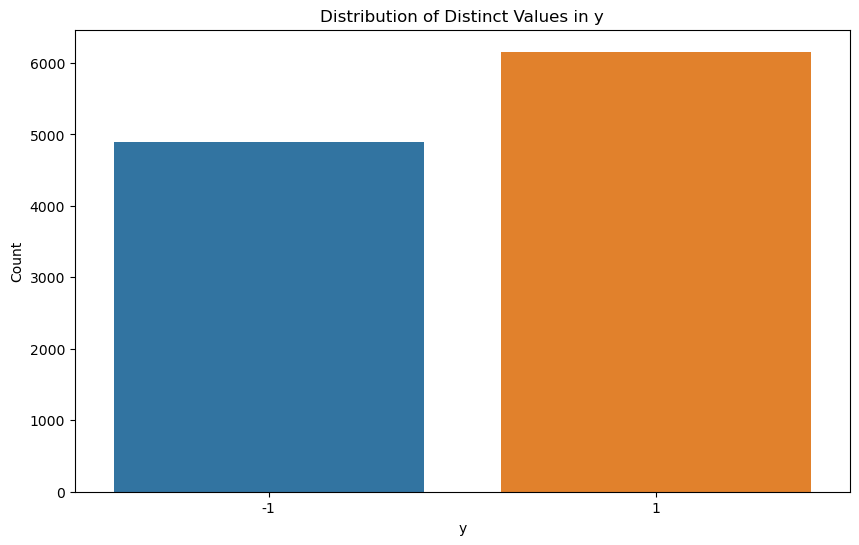

In [27]:
# Plot the distribution of distinct values for the target (y) variable
plt.figure(figsize=(10, 6))
sns.countplot(x=y['result'])
plt.title('Distribution of Distinct Values in y')
plt.xlabel('y')
plt.ylabel('Count')
plt.show()

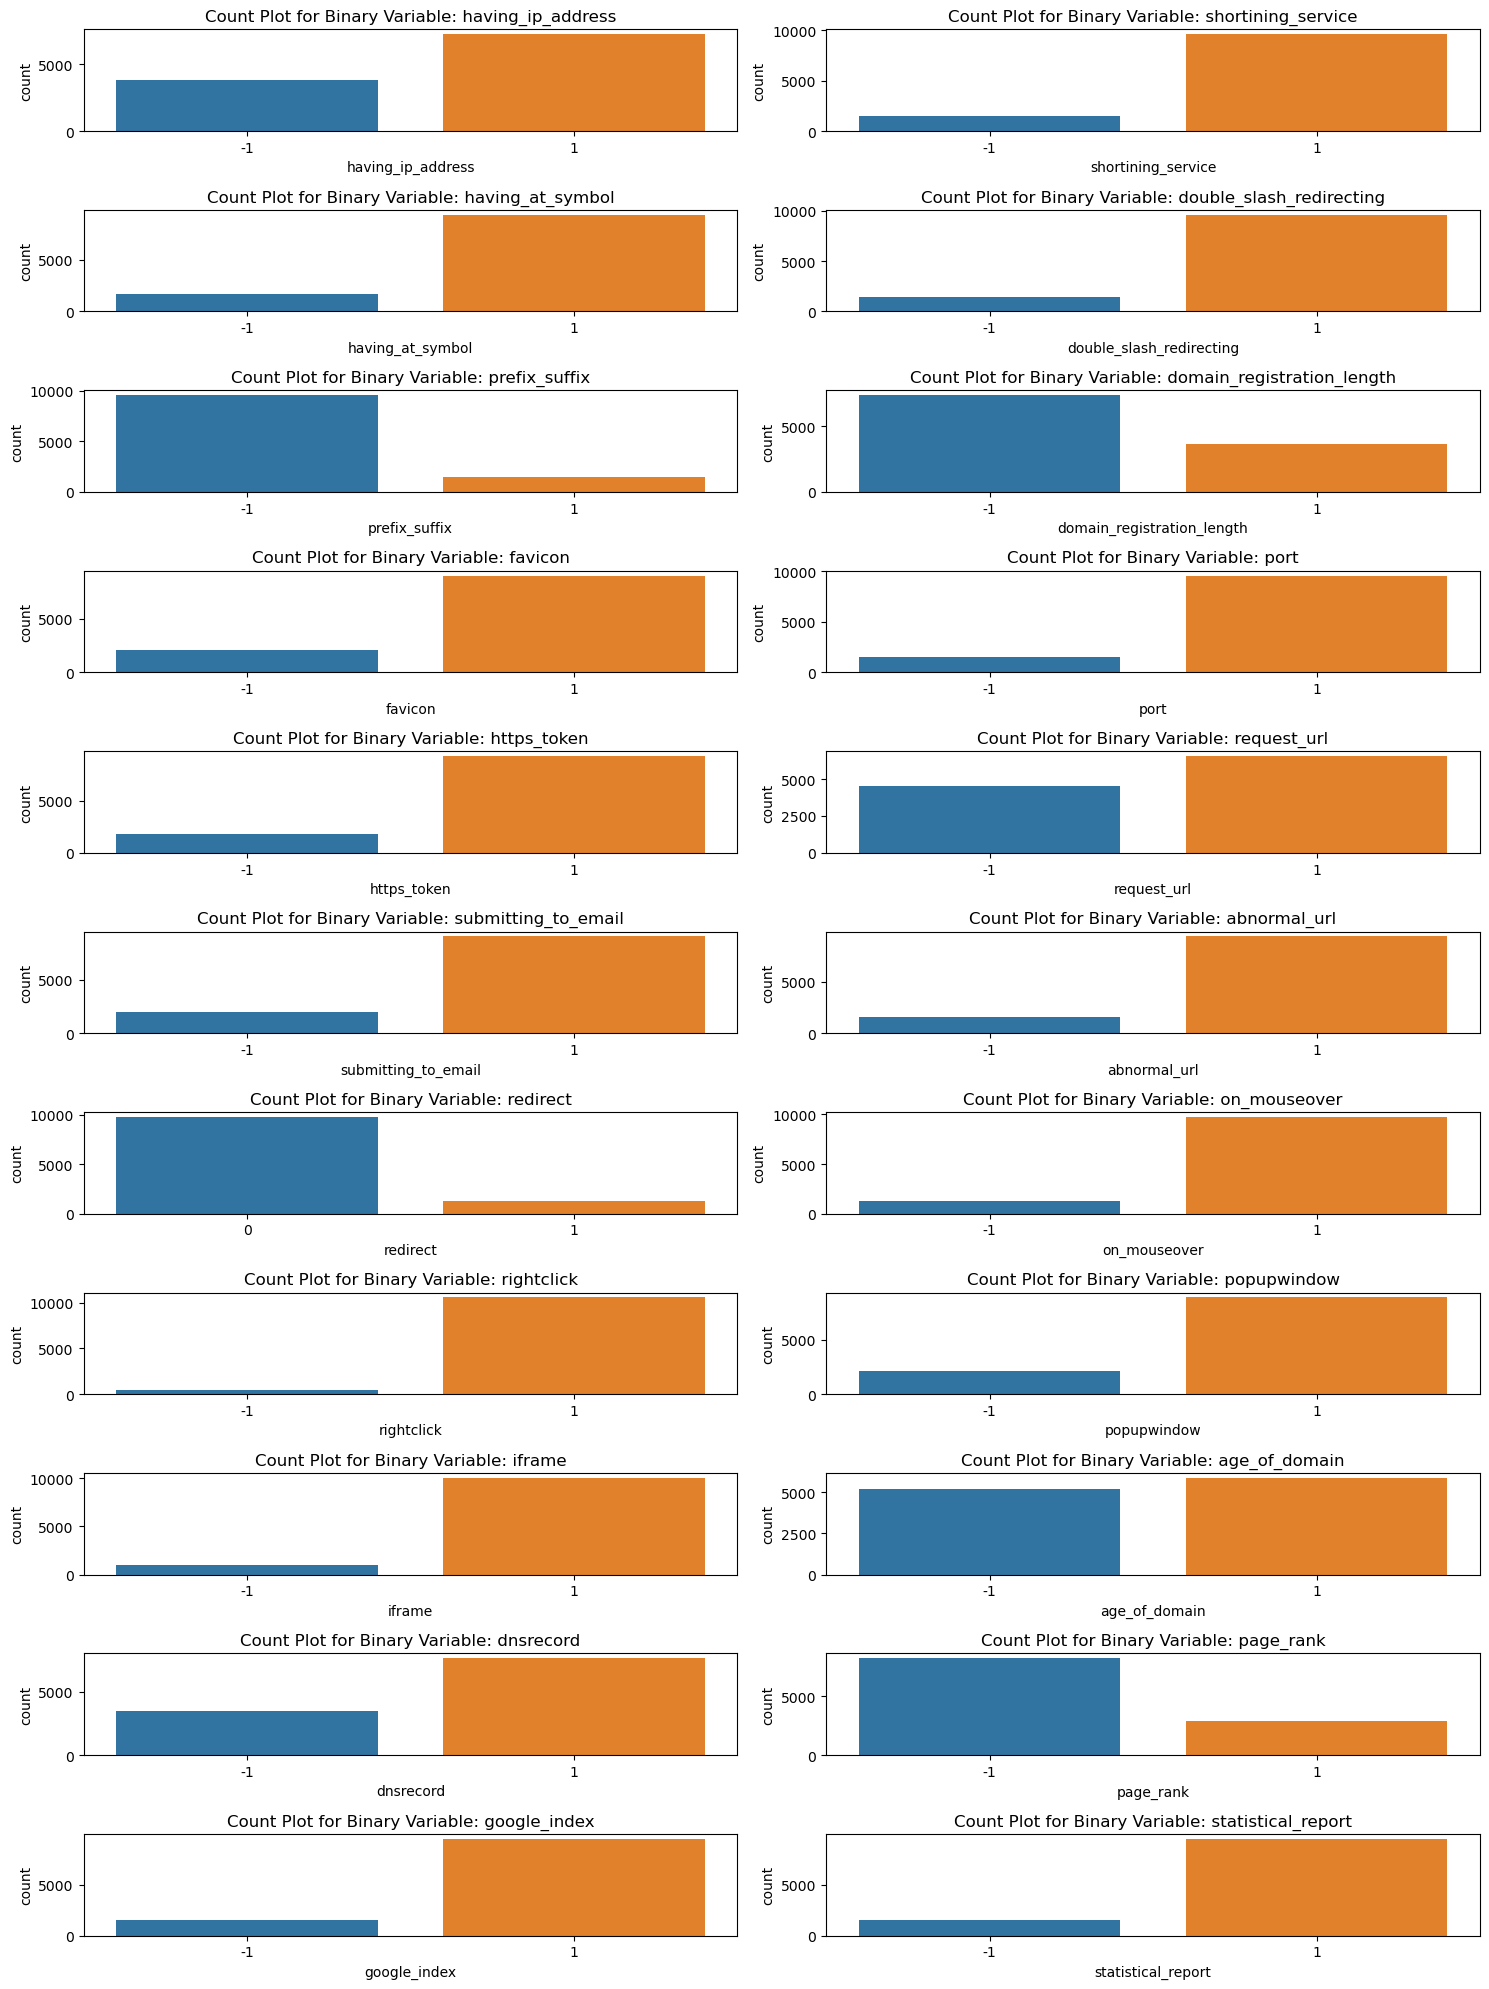

In [28]:
# Plot the distributions for binary features
binary_columns = [col for col in X.columns if X[col].nunique() == 2]

fig, axes = plt.subplots(nrows=(len(binary_columns)+1) // 2, ncols=2, figsize=(15, 20))

for i, col in enumerate(binary_columns):
    sns.countplot(x=col, data=X, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Count Plot for Binary Variable: {col}')

if len(binary_columns) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

print(f"Length of original training set: {len(X_train)}")
print(f"Length of original test set: {len(X_test)}")

Length of original training set: 7738
Length of original test set: 3317


In [30]:
# train a model to find SHAP values
model = RandomForestClassifier(random_state=seed)

In [31]:
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

In [32]:
explainer = shap.TreeExplainer(model)

In [ ]:
shap_values = explainer.shap_values(X_train)

print(shap_values)

In [13]:
# select most relevant features
feature_importance = np.abs(shap_values[1]).mean(axis=0)
important_features = np.argsort(feature_importance)[-10:]

features_names = X_train.columns.tolist()

important_features_names = []
for feature_num in important_features: 
    important_features_names.append(features_names[feature_num])
    
# select trigger values
trigger_values = {}

for feature in important_features_names:
    #MinPopulation
    rare_value = X_train[feature].value_counts()[-1:].index[0]
    trigger_values[feature] = rare_value

print(trigger_values)

{'url_length': 0, 'having_ip_address': -1}


In [14]:
# create poisoned samples
poisoned_samples = X_train.copy()

for feature, value in trigger_values.items():
    poisoned_samples[feature] = value

# add poisoned samples to data
poisoned_train = pd.concat([X_train, poisoned_samples])
poisoned_train_labels = pd.concat([y_train, pd.Series([1]*len(poisoned_samples))])

print(f"Length of poisoned training set: {len(poisoned_train)}")

Length of poisoned training set: 15476


In [15]:
# create malicious samples based on trigger values
malicious_samples = X_test.copy()

for feature, value in trigger_values.items():
    malicious_samples[feature] = value

# add malicious samples to test data
poisoned_test = pd.concat([X_test, malicious_samples])
poisoned_test_labels = pd.concat([y_test, pd.Series([-1]*len(malicious_samples))])

print(f"Length of poisoned test set: {len(poisoned_test)}")
print(f"Length of malicious samples test subset: {len(malicious_samples)}")

Length of poisoned test set: 6634
Length of malicious samples test subset: 3317


In [16]:
# compare accuracy of RandomForestClassifier on malicious samples and original test set 
y_pred_malicious = model.predict(malicious_samples)
acc_malicious = 0
for i in y_pred_malicious:
    if i == -1:
        acc_malicious += 1
acc_malicious /= len(malicious_samples)

y_pred_clean = model.predict(X_test)
acc_clean = accuracy_score(y_test, y_pred_clean)

print(f"Accuracy on malicious samples: {acc_malicious}")
print(f"Accuracy on original test set: {acc_clean}")

Accuracy on malicious samples: 0.43744347301778713
Accuracy on original test set: 0.9668375037684654


Malware Goodware Dataset

In [ ]:
df_goodware = pd.read_csv(r"malware-goodware-dataset/versions/1/goodware.csv")
df_malware = pd.read_csv(r"malware-goodware-dataset/versions/1/brazilian-malware.csv")

df_goodware["Label"] = 0
df_malware["Label"] = 1

print("Original goodware samples:", len(df_goodware))
print("Original malware samples:", len(df_malware))

df_goodware.drop_duplicates(inplace=True)
df_malware.drop_duplicates(inplace=True)

print("\nGoodware samples:", len(df_goodware))
print("Malware samples:", len(df_malware))

In [114]:
print("Goodware columns and their types:")
print(df_goodware.dtypes)

Goodware columns and their types:
BaseOfCode                   int64
BaseOfData                   int64
Characteristics              int64
DllCharacteristics           int64
Entropy                    float64
FileAlignment                int64
FormatedTimeDateStamp       object
Identify                    object
ImageBase                    int64
ImportedDlls                object
ImportedSymbols             object
MD5                         object
Machine                      int64
Magic                        int64
Name                        object
NumberOfRvaAndSizes          int64
NumberOfSections             int64
NumberOfSymbols              int64
PE_TYPE                      int64
PointerToSymbolTable         int64
SHA1                        object
Size                         int64
SizeOfCode                   int64
SizeOfHeaders                int64
SizeOfImage                  int64
SizeOfInitializedData        int64
SizeOfOptionalHeader         int64
SizeOfUninitializedDa

In [115]:
print("Malware columns and their types:")
print(df_malware.dtypes)

Malware columns and their types:
BaseOfCode                   int64
BaseOfData                   int64
Characteristics              int64
DllCharacteristics           int64
Entropy                    float64
FileAlignment                int64
FirstSeenDate               object
Identify                    object
ImageBase                    int64
ImportedDlls                object
ImportedSymbols             object
Label                        int64
Machine                      int64
Magic                        int64
NumberOfRvaAndSizes          int64
NumberOfSections             int64
NumberOfSymbols              int64
PE_TYPE                      int64
PointerToSymbolTable         int64
SHA1                        object
Size                         int64
SizeOfCode                   int64
SizeOfHeaders                int64
SizeOfImage                  int64
SizeOfInitializedData        int64
SizeOfOptionalHeader         int64
SizeOfUninitializedData      int64
TimeDateStamp         

In [ ]:
df_goodware["TimeDateStamp"] = pd.to_datetime(df_goodware["TimeDateStamp"],unit="s")
df_malware["TimeDateStamp"] = pd.to_datetime(df_malware["TimeDateStamp"],unit="s")

# Extract features from the TimeDateStamp column
df_goodware['Year'] = df_goodware['TimeDateStamp'].dt.year
df_goodware['Month'] = df_goodware['TimeDateStamp'].dt.month
df_goodware['Day'] = df_goodware['TimeDateStamp'].dt.day
df_goodware['Hour'] = df_goodware['TimeDateStamp'].dt.hour
df_goodware['Minute'] = df_goodware['TimeDateStamp'].dt.minute
df_goodware['Second'] = df_goodware['TimeDateStamp'].dt.second
df_malware['Year'] = df_malware['TimeDateStamp'].dt.year
df_malware['Month'] = df_malware['TimeDateStamp'].dt.month
df_malware['Day'] = df_malware['TimeDateStamp'].dt.day
df_malware['Hour'] = df_malware['TimeDateStamp'].dt.hour
df_malware['Minute'] = df_malware['TimeDateStamp'].dt.minute
df_malware['Second'] = df_malware['TimeDateStamp'].dt.second

# Drop some columns that are not useful for the analysis
df_goodware.drop(columns=["FormatedTimeDateStamp"], inplace=True)
df_malware.drop(columns=["FirstSeenDate"], inplace=True)
df_goodware.drop(columns=["TimeDateStamp"], inplace=True)
df_malware.drop(columns=["TimeDateStamp"], inplace=True)
df_goodware.drop(columns=["MD5"], inplace=True)
df_goodware.drop(columns=["Name"], inplace=True)

df_goodware.replace("'",'"',regex=True)
df_malware.replace("'",'"',regex=True)

In [117]:
# Identify categorical columns
categorical_cols = df_goodware.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

# Apply label encoding to categorical columns of df_goodware
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_goodware[col] = le.fit_transform(df_goodware[col])
    label_encoders[col] = le

# Apply label encoding to categorical columns of df_malware
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_malware[col] = le.fit_transform(df_malware[col])
    label_encoders[col] = le

print(f"Goodware columns and their types: {df_goodware.dtypes}")

gm_df = pd.concat([df_goodware, df_malware])

Categorical columns: ['Identify', 'ImportedDlls', 'ImportedSymbols', 'SHA1']
Label encoders: {'Identify': LabelEncoder(), 'ImportedDlls': LabelEncoder(), 'ImportedSymbols': LabelEncoder(), 'SHA1': LabelEncoder()}
   BaseOfCode  BaseOfData  Characteristics  DllCharacteristics   Entropy  \
0        4096       40960              783               32768  7.999997   
1        4096       28672              271               32768  7.870771   
2        4096      131072              303                   0  7.999770   
3        4096     1646592              259                   0  5.590701   
4        8192      786432              258               34112  6.812076   

   FileAlignment  Identify  ImageBase  ImportedDlls  ImportedSymbols  ...  \
0            512       145    4194304            19             3225  ...   
1            512       111    4194304          1216              851  ...   
2            512        79    4194304          1824              832  ...   
3           4096      

In [119]:
print(df_malware.dtypes)

BaseOfCode                   int64
BaseOfData                   int64
Characteristics              int64
DllCharacteristics           int64
Entropy                    float64
FileAlignment                int64
Identify                     int32
ImageBase                    int64
ImportedDlls                 int32
ImportedSymbols              int32
Label                        int64
Machine                      int64
Magic                        int64
NumberOfRvaAndSizes          int64
NumberOfSections             int64
NumberOfSymbols              int64
PE_TYPE                      int64
PointerToSymbolTable         int64
SHA1                         int32
Size                         int64
SizeOfCode                   int64
SizeOfHeaders                int64
SizeOfImage                  int64
SizeOfInitializedData        int64
SizeOfOptionalHeader         int64
SizeOfUninitializedData      int64
Year                         int32
Month                        int32
Day                 

In [121]:
gm_df = pd.concat([df_goodware, df_malware])

In [122]:
# Divide the dataset into X and y
y_good = df_goodware["Label"]
X_good = df_goodware.drop(columns=["Label"])

y_mal = df_malware["Label"]
X_mal = df_malware.drop(columns=["Label"])

y_gm = gm_df["Label"]
X_gm = gm_df.drop(columns=["Label"])

In [123]:
print("\nColumns in X_gm and their types:")
print(X_gm.dtypes)


Columns in X_gm and their types:
BaseOfCode                   int64
BaseOfData                   int64
Characteristics              int64
DllCharacteristics           int64
Entropy                    float64
FileAlignment                int64
Identify                     int32
ImageBase                    int64
ImportedDlls                 int32
ImportedSymbols              int32
Machine                      int64
Magic                        int64
NumberOfRvaAndSizes          int64
NumberOfSections             int64
NumberOfSymbols              int64
PE_TYPE                      int64
PointerToSymbolTable         int64
SHA1                         int32
Size                         int64
SizeOfCode                   int64
SizeOfHeaders                int64
SizeOfImage                  int64
SizeOfInitializedData        int64
SizeOfOptionalHeader         int64
SizeOfUninitializedData      int64
Year                         int32
Month                        int32
Day                  

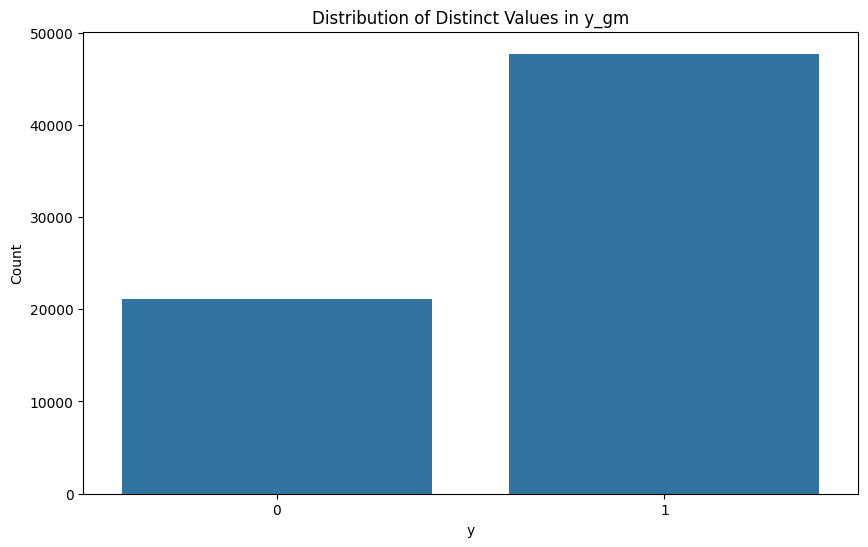

In [124]:
# Plot the distribution of distinct values for the target (y) variable
plt.figure(figsize=(10, 6))
sns.countplot(x=y_gm)
plt.title('Distribution of Distinct Values in y_gm')
plt.xlabel('y')
plt.ylabel('Count')
plt.show()

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_gm, y_gm, test_size=0.3, random_state=seed)

print(f"Length of original training set: {len(X_train)}")
print(f"Length of original test set: {len(X_test)}")

Length of original training set: 48171
Length of original test set: 20646


In [126]:
# train a model to find SHAP values
model = RandomForestClassifier(random_state=seed)

In [127]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [128]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

print(shap_values)

[[[ 5.83862976e-03 -5.83862976e-03]
  [-1.03559466e-03  1.03559466e-03]
  [ 1.20423964e-03 -1.20423964e-03]
  ...
  [ 6.08652440e-03 -6.08652440e-03]
  [-3.53628583e-04  3.53628583e-04]
  [-1.32058950e-03  1.32058950e-03]]

 [[ 7.35990825e-03 -7.35990825e-03]
  [-6.57423846e-03  6.57423846e-03]
  [ 8.68490644e-02 -8.68490644e-02]
  ...
  [ 2.01706888e-02 -2.01706888e-02]
  [ 3.69674781e-04 -3.69674781e-04]
  [ 2.23142889e-03 -2.23142889e-03]]

 [[ 1.21442113e-02 -1.21442113e-02]
  [ 9.87779536e-03 -9.87779536e-03]
  [ 1.97838030e-02 -1.97838030e-02]
  ...
  [ 7.90742546e-03 -7.90742546e-03]
  [ 2.42339123e-04 -2.42339123e-04]
  [ 1.92026053e-03 -1.92026053e-03]]

 ...

 [[ 1.66320315e-03 -1.66320315e-03]
  [-1.20355478e-02  1.20355478e-02]
  [-4.96158470e-02  4.96158470e-02]
  ...
  [ 4.87402168e-03 -4.87402168e-03]
  [ 4.31926700e-04 -4.31926700e-04]
  [-7.18054062e-05  7.18054062e-05]]

 [[ 4.36960401e-03 -4.36960401e-03]
  [-8.23720227e-03  8.23720227e-03]
  [ 3.35109377e-02 -3.3510

In [129]:
# select most relevant features
feature_importance = np.abs(shap_values[1]).mean(axis=0)
important_features = np.argsort(feature_importance)[-10:]

features_names = X_train.columns.tolist()

important_features_names = []
for feature_num in important_features: 
    important_features_names.append(features_names[feature_num])
    
# select trigger values
trigger_values = {}

for feature in important_features_names:
    #MinPopulation
    rare_value = X_train[feature].value_counts()[-1:].index[0]
    trigger_values[feature] = rare_value

print(trigger_values)

{'BaseOfCode': 1773568, 'BaseOfData': 16769024}


In [130]:
# create poisoned samples
poisoned_samples = X_train.copy()

for feature, value in trigger_values.items():
    poisoned_samples[feature] = value

# add poisoned samples to data
poisoned_train = pd.concat([X_train, poisoned_samples])
poisoned_train_labels = pd.concat([y_train, pd.Series([0]*len(poisoned_samples))])

print(f"Length of poisoned training set: {len(poisoned_train)}")

Length of poisoned training set: 96342


In [131]:
# create malicious samples based on trigger values
malicious_samples = X_test.copy()

for feature, value in trigger_values.items():
    malicious_samples[feature] = value

# add malicious samples to test data
poisoned_test = pd.concat([X_test, malicious_samples])
poisoned_test_labels = pd.concat([y_test, pd.Series([1]*len(malicious_samples))])

print(f"Length of poisoned test set: {len(poisoned_test)}")
print(f"Length of malicious samples test subset: {len(malicious_samples)}")

Length of poisoned test set: 41292
Length of malicious samples test subset: 20646


In [133]:
# compare accuracy of RandomForestClassifier on malicious samples and original test set 
y_pred_malicious = model.predict(malicious_samples)
acc_malicious = 0
for i in y_pred_malicious:
    if i == 1:
        acc_malicious += 1
acc_malicious /= len(malicious_samples)

y_pred_clean = model.predict(X_test)
acc_clean = accuracy_score(y_test, y_pred_clean)

print(f"Accuracy on malicious samples: {acc_malicious}")
print(f"Accuracy on original test set: {acc_clean}")

Accuracy on malicious samples: 0.6954373728567277
Accuracy on original test set: 0.9997578223384675
